## LSTM

In deze notebook worden er LSTM modellen getrained. Er wordt getrained op basis van tweet, op basis van metadata en een combinatie van de twee.

<span style="color:red"> ! Note:</span> om de notebook te runnen, moeten de datasets van 2021 en 2022 beide beschikbaar zijn in de folder 'data/cleaned_data'. Run dus eerst data_tools.py (in tools folder) en de clean_text_data.py in de folder van 2021 om ze te verkrijgen.
### Imports

In [26]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [2]:
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print("No GPU found")

GPU found
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-06 14:24:40.064479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-06 14:24:40.064632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load data

In [3]:
FILE_PATH_2022 = '../../data/cleaned_data/cleaned_text_data_2022.csv'
FILE_PATH_2021 = '../../data/cleaned_data/clean_text_2021.csv'

data_2022 = pd.read_csv(FILE_PATH_2022)
data_2021 = pd.read_csv(FILE_PATH_2021)

In [4]:
data_2021.shape, data_2022.shape

((13521, 3), (7903, 4))

In [5]:
data_2021['real_fake_grade'] = data_2021['label']

data_2021.drop('label', axis=1, inplace=True)

In [6]:
data_2022.isna().sum()

full_text          0
real_fake_grade    0
text_metadata      0
combined           0
dtype: int64

### Models

In [7]:
MAX_LEN = 80
MAX_WORDS = 512
embedding_size = 32
epochs=10
batch_size=64

In [21]:
def retrieve_data(column_name: str, data_name: str, max_len=MAX_LEN):
    """Returned vectorized data gesplistst in train en test"""

    if column_name not in data_name.columns:
        raise Exception(f"{column_name} not in dataframe")

    # Maak X en y variabelen aan
    X = data_name[column_name]
    y = data_name['real_fake_grade']

    # Text tokenization
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(X)
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len, padding='post')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print('Train Set ->', X_train.shape, y_train.shape)
    print('Test Set ->', X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [13]:
def create_model(input_dim=MAX_WORDS):
    model = Sequential()

    model.add(Embedding(input_dim=input_dim, output_dim=64))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
def show_results(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title)

    axes[0].set_title('Accuracy')
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set(xlabel='epoch', ylabel='accuracy')

    axes[1].set_title('Loss')
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set(xlabel='epoch', ylabel='loss')    
    
    plt.tight_layout()
    plt.show()

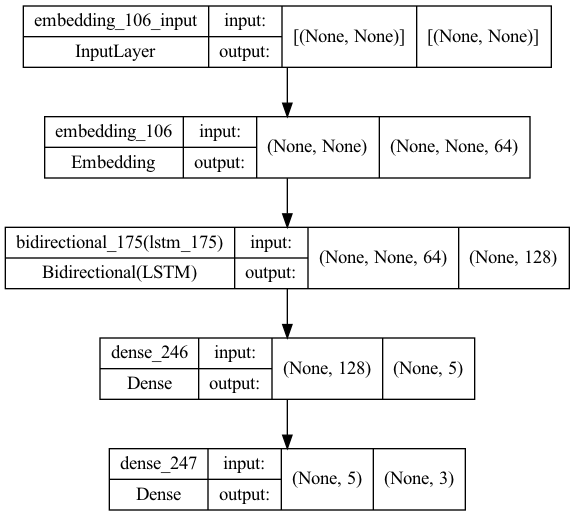

In [24]:
example_model = create_model()
plot_model(example_model, show_shapes=True)

#### Tweets

##### Tweets 2022 dataset

In [25]:
X_train, y_train, X_test, y_test, X_val, y_val = retrieve_data('full_text', data_2022)

Train Set -> (4741, 80) (4741,)
Test Set -> (1976, 80) (1976,)


In [13]:
tweet_2022 = KerasClassifier(build_fn=create_model, input_dim=MAX_WORDS)

In [14]:
start = time()
history = tweet_2022.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

tweet_2022_train_time = end - start

2022-06-02 18:13:39.076787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-02 18:13:39.076811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2022-06-02 18:13:39.527649: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-02 18:13:40.713688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:41.111031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:41.121426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:41.307954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:41.318463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:41.571915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

178/178 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.5465

2022-06-02 18:13:58.448645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:58.587144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:58.594355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:58.757968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:13:58.765547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - 20s 100ms/step - loss: 0.9558 - accuracy: 0.5465 - val_loss: 0.9179 - val_accuracy: 0.5640
Epoch 2/10
178/178 [==============================] - 16s 90ms/step - loss: 0.7863 - accuracy: 0.6390 - val_loss: 0.7452 - val_accuracy: 0.6130
Epoch 3/10
178/178 [==============================] - 16s 91ms/step - loss: 0.6889 - accuracy: 0.6956 - val_loss: 0.7037 - val_accuracy: 0.6888
Epoch 4/10
178/178 [==============================] - 16s 92ms/step - loss: 0.6461 - accuracy: 0.7246 - val_loss: 0.7118 - val_accuracy: 0.6919
Epoch 5/10
178/178 [==============================] - 16s 91ms/step - loss: 0.6037 - accuracy: 0.7497 - val_loss: 0.7283 - val_accuracy: 0.7125
Epoch 6/10
178/178 [==============================] - 16s 89ms/step - loss: 0.5782 - accuracy: 0.7574 - val_loss: 0.6952 - val_accuracy: 0.7172
Epoch 7/10
178/178 [==============================] - 16s 89ms/step - loss: 0.5548 - accuracy: 0.7687 - val_loss: 0.7052 - val_accuracy: 0.6935
Ep

In [15]:
pred = tweet_2022.predict(X_test)

start = time()
full_text_accuracy = accuracy_score(y_test, pred)
end = time()

tweet_2022_test_time = end - start

2022-06-02 18:16:31.703956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:16:31.823691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:16:31.832447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:16:31.996565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:16:32.004713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
print(f"Train time: {tweet_2022_train_time}")
print(f"Test time: {tweet_2022_test_time}")
print(f"Accuracy: {full_text_accuracy}")

Train time: 165.01144695281982
Test time: 0.00033020973205566406
Accuracy: 0.698292220113852


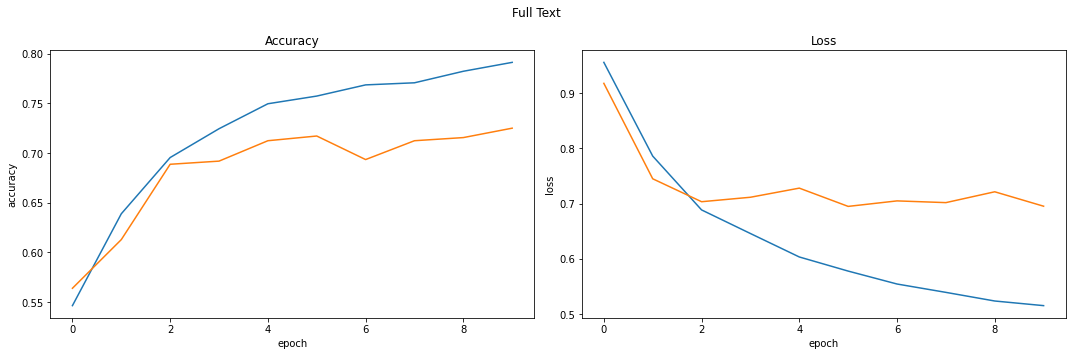

In [17]:
show_results(history, 'Full Text')

##### Tweets 2021 dataset

In [68]:
X_train, y_train, X_test, y_test = retrieve_data('text', data_2021)

Train Set -> (10140, 80) (10140,)
Test Set -> (3381, 80) (3381,)


In [69]:
tweet_2021 = KerasClassifier(build_fn=create_model, input_dim=MAX_LEN)

start = time()
history = tweet_2021.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

tweet_2021_train_time = end - start

Epoch 1/10


2022-06-02 20:57:25.676215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:26.297073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:26.310461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:26.625495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:26.640038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:27.102926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:57:27.122940: I tensorflow/core/grappler/optimizers/cust

286/286 [==============================] - ETA: 0s - loss: 0.7548 - accuracy: 0.6672

2022-06-02 20:58:02.952930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:58:03.161138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:58:03.170586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:58:03.445482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 20:58:03.455011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 42s 133ms/step - loss: 0.7548 - accuracy: 0.6672 - val_loss: 0.6823 - val_accuracy: 0.7140
Epoch 2/10
286/286 [==============================] - 34s 117ms/step - loss: 0.6435 - accuracy: 0.7326 - val_loss: 0.6308 - val_accuracy: 0.7367
Epoch 3/10
286/286 [==============================] - 34s 118ms/step - loss: 0.6001 - accuracy: 0.7441 - val_loss: 0.5649 - val_accuracy: 0.7673
Epoch 4/10
286/286 [==============================] - 34s 119ms/step - loss: 0.5773 - accuracy: 0.7518 - val_loss: 0.5667 - val_accuracy: 0.7663
Epoch 5/10
286/286 [==============================] - 34s 119ms/step - loss: 0.5641 - accuracy: 0.7633 - val_loss: 0.5526 - val_accuracy: 0.7830
Epoch 6/10
286/286 [==============================] - 33s 117ms/step - loss: 0.5550 - accuracy: 0.7661 - val_loss: 0.5434 - val_accuracy: 0.7791
Epoch 7/10
286/286 [==============================] - 33s 117ms/step - loss: 0.5433 - accuracy: 0.7719 - val_loss: 0.5286 - val_accuracy: 0.7

In [70]:
pred = tweet_2021.predict(X_test)

tweet_2021_accuracy = accuracy_score(y_test, pred)
tweet_2021_accuracy

2022-06-02 21:04:32.721559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 21:04:32.911596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 21:04:32.923191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 21:04:33.233819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 21:04:33.243299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.7793552203490092

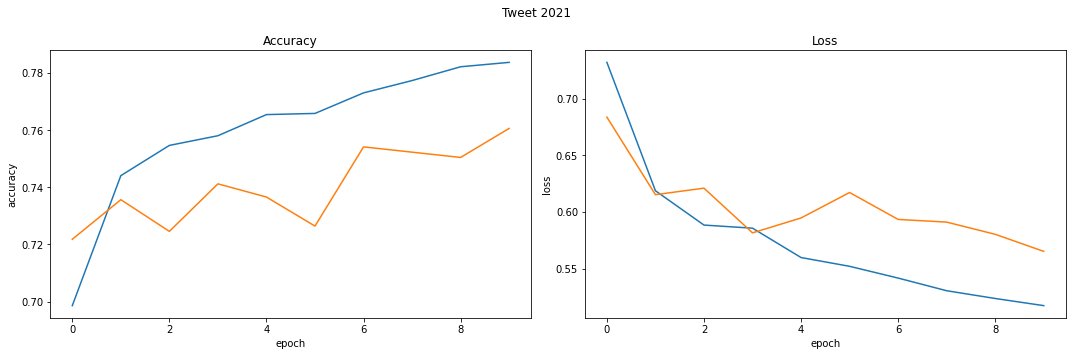

In [56]:
show_results(history, 'Tweet 2021')

---

#### Text metadata

In [22]:
X_train, y_train, X_test, y_test = retrieve_data('text_metadata', data_2022)

Train Set -> (6322, 80) (6322,)
Test Set -> (1581, 80) (1581,)


In [23]:
text_metadata = KerasClassifier(build_fn=create_model, input_dim=MAX_WORDS)

start = time()
history = text_metadata.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

text_metadata_train_time = end - start

Epoch 1/10


2022-06-02 18:23:35.960525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.371370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.381750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.566244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.576948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.820384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:36.835929: I tensorflow/core/grappler/optimizers/cust

178/178 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.6333

2022-06-02 18:23:54.561044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:54.700108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:54.707439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:54.879465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:23:54.886919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - 22s 106ms/step - loss: 0.7780 - accuracy: 0.6333 - val_loss: 0.6567 - val_accuracy: 0.6603
Epoch 2/10
178/178 [==============================] - 16s 93ms/step - loss: 0.6186 - accuracy: 0.7094 - val_loss: 0.6424 - val_accuracy: 0.6761
Epoch 3/10
178/178 [==============================] - 17s 93ms/step - loss: 0.5916 - accuracy: 0.7209 - val_loss: 0.6346 - val_accuracy: 0.6793
Epoch 4/10
178/178 [==============================] - 17s 93ms/step - loss: 0.5724 - accuracy: 0.7240 - val_loss: 0.6451 - val_accuracy: 0.6761
Epoch 5/10
178/178 [==============================] - 16s 91ms/step - loss: 0.5598 - accuracy: 0.7298 - val_loss: 0.6371 - val_accuracy: 0.6809
Epoch 6/10
178/178 [==============================] - 17s 93ms/step - loss: 0.5481 - accuracy: 0.7330 - val_loss: 0.6507 - val_accuracy: 0.6667
Epoch 7/10
178/178 [==============================] - 17s 93ms/step - loss: 0.5387 - accuracy: 0.7376 - val_loss: 0.6550 - val_accuracy: 0.6935
Ep

In [24]:
start = time()
pred = text_metadata.predict(X_test)
end = time()

text_metadata_acc = accuracy_score(y_test, pred)

text_metadata_test_time = end - start

2022-06-02 18:26:50.752822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:26:50.879231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:26:50.888151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:26:51.064969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:26:51.072533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [25]:
print(f"Train time: {text_metadata_train_time}")
print(f"Test time: {text_metadata_test_time}")
print(f"Accuracy: {text_metadata_acc}")

Train time: 170.9451880455017
Test time: 3.064103364944458
Accuracy: 0.6963946869070209


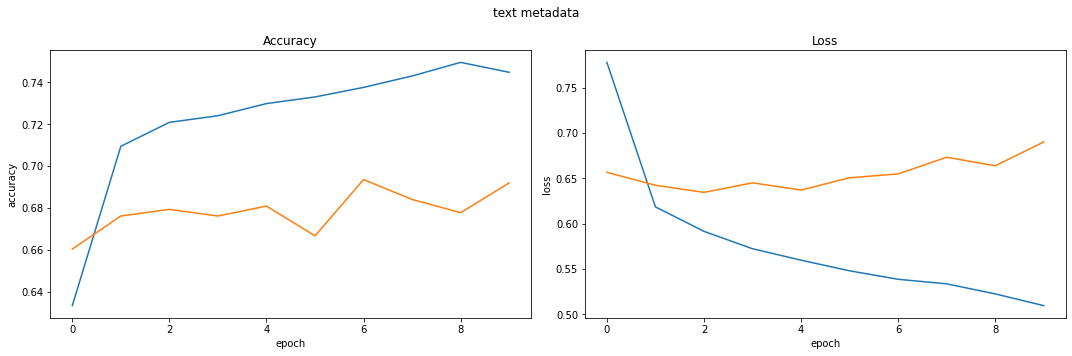

In [26]:
show_results(history, 'text metadata')

---

#### Combined columns

In [27]:
X_train, y_train, X_test, y_test = retrieve_data('combined', data_2022)

Train Set -> (6322, 80) (6322,)
Test Set -> (1581, 80) (1581,)


In [28]:
combined_model = KerasClassifier(build_fn=create_model, input_dim=MAX_WORDS)
start = time()
history = combined_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

combined_time = end - start

Epoch 1/10


2022-06-02 18:27:41.036925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.453874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.464208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.654034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.664861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.948356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:41.964060: I tensorflow/core/grappler/optimizers/cust

178/178 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.6335

2022-06-02 18:27:59.064473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:59.206074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:59.213246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:59.389062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:27:59.396800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - 21s 102ms/step - loss: 0.7808 - accuracy: 0.6335 - val_loss: 0.6297 - val_accuracy: 0.6856
Epoch 2/10
178/178 [==============================] - 16s 89ms/step - loss: 0.5873 - accuracy: 0.7290 - val_loss: 0.5954 - val_accuracy: 0.7172
Epoch 3/10
178/178 [==============================] - 16s 90ms/step - loss: 0.5528 - accuracy: 0.7469 - val_loss: 0.5835 - val_accuracy: 0.7378
Epoch 4/10
178/178 [==============================] - 16s 89ms/step - loss: 0.5285 - accuracy: 0.7646 - val_loss: 0.5876 - val_accuracy: 0.7346
Epoch 5/10
178/178 [==============================] - 16s 91ms/step - loss: 0.5022 - accuracy: 0.7755 - val_loss: 0.5890 - val_accuracy: 0.7299
Epoch 6/10
178/178 [==============================] - 16s 91ms/step - loss: 0.4916 - accuracy: 0.7820 - val_loss: 0.5853 - val_accuracy: 0.7188
Epoch 7/10
178/178 [==============================] - 16s 91ms/step - loss: 0.4849 - accuracy: 0.7812 - val_loss: 0.5925 - val_accuracy: 0.7267
Ep

In [29]:
start = time()
pred = combined_model.predict(X_test)
end = time()

combined_test_time = end - start

combined_acc = accuracy_score(y_test, pred)

2022-06-02 18:30:40.713878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:30:40.837149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:30:40.845875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:30:41.034573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 18:30:41.042882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [30]:
print(f"Train time: {combined_time}")
print(f"Test time: {combined_test_time}")
print(f"accuracy: {combined_acc}")

Train time: 165.72872710227966
Test time: 3.4043798446655273
accuracy: 0.7381404174573055


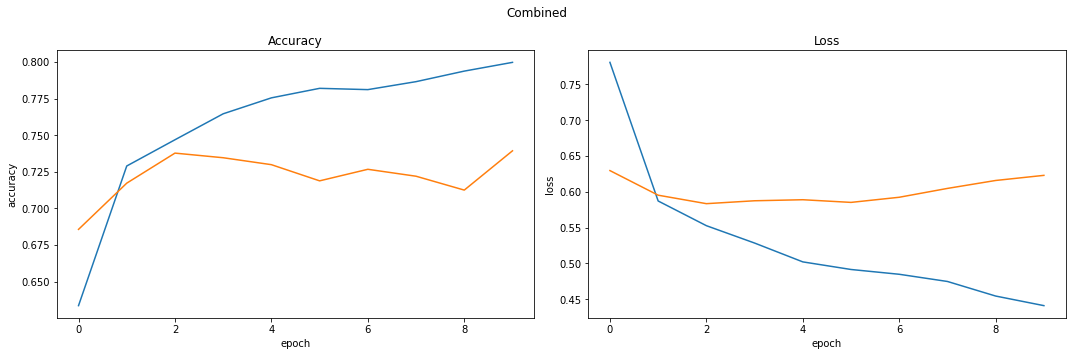

In [31]:
show_results(history, 'Combined')

#### Save model

In [32]:
combined_model.model.save('./results/lstm/lstm_combined.h5')
text_metadata.model.save('./results/lstm/lstm_text_metadata.h5')
tweet_2022.model.save('./results/lstm/lstm_tweet.h5')

### Resultaten


|      	| accuracy 	| training time (s)     	| test time  (s)|
|------	|-------------	|-------	| ------|
| Tweet 2021 	|    0.801    	|  273  | 0.1|
| Tweet 2022    	|   0.698     |240	| 0.001 |
| Text metadata    	| 0.696      |210 	| 0.001|
| Combined    	| 0.738        	| 250| 3.2|


### Conclusie

Een combinatie van user info en de tweet zelf geeft een hogere percentage bij het voorspellen met een LSTM model.